In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() #interactive mode

## Load Data

In [6]:
# We do Data augmentation and normalization for training
# But only data normalization for validation
data_transforms= {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir='data/hymenoptera_data'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),
                                       data_transforms[x])
               for x in ['train','val']}
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x],
                                           batch_size=4,
                                           shuffle=True, num_workers=4)
            for x in ['train','val']}
dataset_sizes={x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Visualize a few images to check

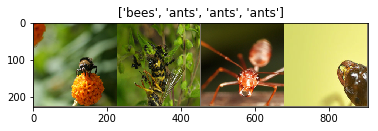

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp=inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std*inp+mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit for th plots to update

#Get a batch for training data
inputs, classes = next(iter(dataloaders['train']))

#Make Grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

In [13]:
# We will do the following
#1) Schedule a training rate
#2) Save the best model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since=time.time()
    
    best_model_wts= copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        #Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Train model
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs =inputs.to(device)
                labels=labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #Forward Propogation
                with torch.set_grad_enabled(phase == 'train'):
                    outputs=model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimimze only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double()/ dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### Visualize model predictions

In [14]:
def visualize_model(model, num_images=6):
    was_training=model.training
    model.eval()
    images_so_far = 0
    fig=plt.figure()
    
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    

### Fine- Tuning the ConvNet

#### Load a pretrained model and reset final FC layer

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft=model_ft.to(device)

criterion =nn.CrossEntropyLoss()
#Observe that all parameters are being optimized

optimizer_ft = optim.SGD(model_ft.parameters(), lr =0.001, momentum =0.9)

#Decay the Learning Rate by a factor of 0.1 for every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


#### Train and evaluate the model 
##### About 15-20 mins on CPU and 1 min on GPU


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6327 Acc: 0.6721
val Loss: 0.2119 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4346 Acc: 0.7828
val Loss: 0.2386 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4612 Acc: 0.7787
val Loss: 0.2546 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5352 Acc: 0.8279
val Loss: 0.2075 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4454 Acc: 0.8156
val Loss: 0.3778 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4391 Acc: 0.8361
val Loss: 0.3718 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.2806 Acc: 0.8934
val Loss: 0.4160 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.4758 Acc: 0.8525
val Loss: 0.3094 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3304 Acc: 0.8566
val Loss: 0.2617 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3618 Acc: 0.8320
val Loss: 0.2494 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2580 Acc: 0.8893
val Loss: 0.2492 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2705 Acc: 0.8852
val Loss: 0.2674 Acc: 0.9020

Ep

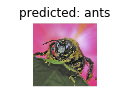

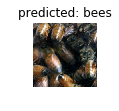

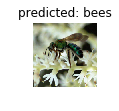

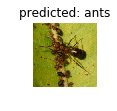

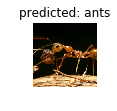

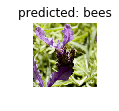

In [18]:
visualize_model(model_ft)

### ConvNet as Fixed Feature Extractor
#### we freeze the whole network except the last FC layer

In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
#Parameters of newly constructed modules have requires_grad =True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv=model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Train and evaluate

In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6498 Acc: 0.6557
val Loss: 0.2925 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4068 Acc: 0.8197
val Loss: 0.2029 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4023 Acc: 0.8115
val Loss: 0.1944 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.6402 Acc: 0.7213
val Loss: 0.1623 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.4661 Acc: 0.7664
val Loss: 0.1674 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4380 Acc: 0.8238
val Loss: 0.2792 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4997 Acc: 0.7787
val Loss: 0.1889 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4061 Acc: 0.7992
val Loss: 0.1834 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3290 Acc: 0.8525
val Loss: 0.1872 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2379 Acc: 0.8975
val Loss: 0.1807 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3632 Acc: 0.8402
val Loss: 0.1859 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3021 Acc: 0.8648
val Loss: 0.2134 Acc: 0.9346

Ep

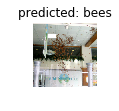

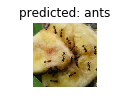

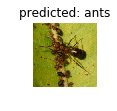

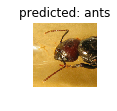

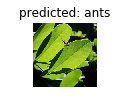

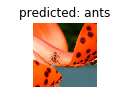

In [21]:
visualize_model(model_conv)

plt.ioff()
plt.show()